,Hypothesis,n,Pearson_r,p_value,p_value_sci,R_squared
0,H1: (BB+HBP)/PA → OBP,50,0.492926,2.760795e-04,2.760795275361e-04,0.242976
1,H2: SO/PA → OBP,50,-0.530346,7.449893e-05,7.449892909288e-05,0.281267
2,H3: OBP → wRC+,50,0.718129,4.341020e-09,4.341020039645e-09,0.515709


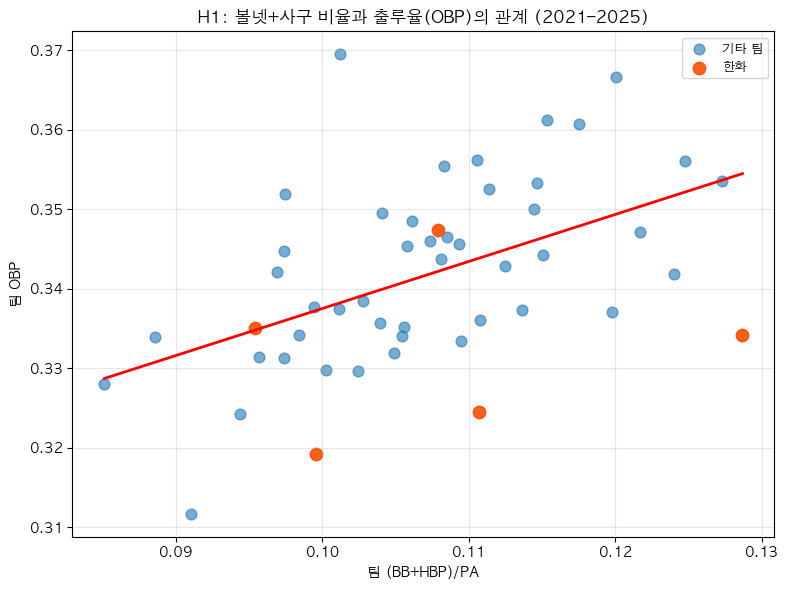

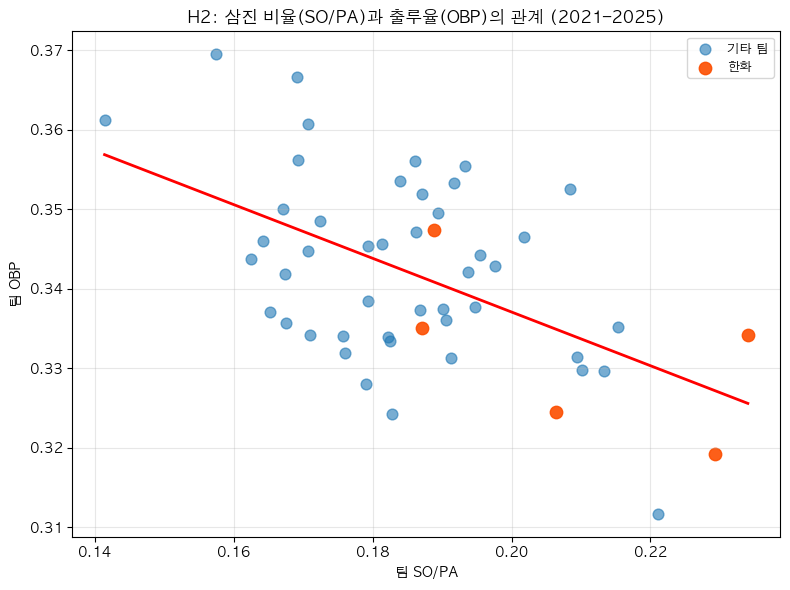

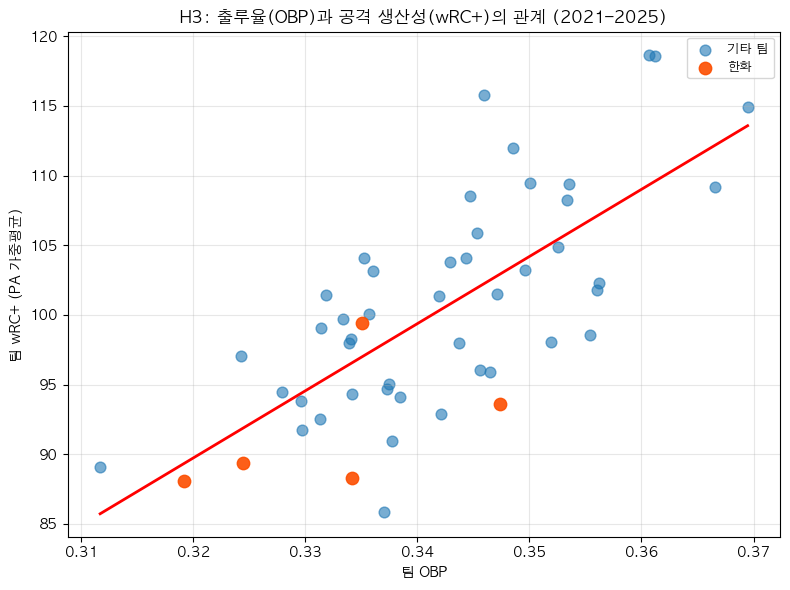

In [1]:
# ============================================================
# 05_hypothesis_tests_clean_unified_style.ipynb (복붙 즉시 실행용)
# - 표 1개(stats_df_precise)
# - 그래프 3개(H1~H3) : "네가 준 H1 스타일"로 통일
#   (기타 팀 기본 점 + 한화 강조 + 전체 회귀선 + grid + legend)
# ============================================================

# -----------------------------
# 0) 라이브러리
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm

plt.rcParams["font.family"] = "AppleGothic"
plt.rcParams["axes.unicode_minus"] = False

# -----------------------------
# 1) 데이터 로드 + 최근 5개년 필터
# -----------------------------
BAT_PATH = "../data/raw/kbo_batting_stats_by_season_1982-2025.csv"
YEARS = [2021, 2022, 2023, 2024, 2025]

bat = pd.read_csv(BAT_PATH)
bat5 = bat[bat["Year"].isin(YEARS)].copy()

# 필요한 컬럼 체크
required_cols = ["Year", "Team", "PA", "AB", "H", "BB", "HP", "SF", "SO", "wRC+"]
missing = [c for c in required_cols if c not in bat5.columns]
if missing:
    raise KeyError(f"필수 컬럼이 없습니다: {missing}")

# 수치형 변환
num_cols = ["PA", "AB", "H", "BB", "HP", "SF", "SO", "wRC+"]
for c in num_cols:
    bat5[c] = pd.to_numeric(bat5[c], errors="coerce")

# 결측/0 제거(안전장치)
bat5 = bat5.dropna(subset=num_cols)
bat5 = bat5[(bat5["PA"] > 0) & (bat5["AB"] > 0)].copy()

# -----------------------------
# 2) Team-Year 집계 + 파생 변수
# -----------------------------
bat5["wRCxPA"] = bat5["wRC+"] * bat5["PA"]

team_year = (
    bat5.groupby(["Year", "Team"], as_index=False)
        .agg(
            PA=("PA", "sum"),
            AB=("AB", "sum"),
            H=("H", "sum"),
            BB=("BB", "sum"),
            HBP=("HP", "sum"),  # HP=HBP(사구)
            SF=("SF", "sum"),
            SO=("SO", "sum"),
            wRCxPA=("wRCxPA", "sum"),
        )
)

# OBP 재계산(근사)
team_year["OBP"] = (team_year["H"] + team_year["BB"] + team_year["HBP"]) / (
    team_year["AB"] + team_year["BB"] + team_year["HBP"] + team_year["SF"]
)

team_year["BB_HBP_PA"] = (team_year["BB"] + team_year["HBP"]) / team_year["PA"]
team_year["SO_PA"] = team_year["SO"] / team_year["PA"]
team_year["wRC+_PAw"] = team_year["wRCxPA"] / team_year["PA"]

team_year = team_year.replace([np.inf, -np.inf], np.nan).dropna(
    subset=["OBP", "BB_HBP_PA", "SO_PA", "wRC+_PAw"]
).copy()

# -----------------------------
# 3) 정밀 통계 테이블
# -----------------------------
def hypothesis_table_precise(df, xcol, ycol, name):
    x = pd.to_numeric(df[xcol], errors="coerce")
    y = pd.to_numeric(df[ycol], errors="coerce")
    mask = ~(x.isna() | y.isna())
    x = x[mask]
    y = y[mask]

    r, p = st.pearsonr(x, y)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    return {
        "Hypothesis": name,
        "n": int(len(x)),
        "Pearson_r": float(r),
        "p_value": float(p),
        "p_value_sci": f"{p:.12e}",
        "R_squared": float(model.rsquared),
    }

stats_df_precise = pd.DataFrame([
    hypothesis_table_precise(team_year, "BB_HBP_PA", "OBP", "H1: (BB+HBP)/PA → OBP"),
    hypothesis_table_precise(team_year, "SO_PA", "OBP", "H2: SO/PA → OBP"),
    hypothesis_table_precise(team_year, "OBP", "wRC+_PAw", "H3: OBP → wRC+"),
])

try:
    display(stats_df_precise)
except NameError:
    print(stats_df_precise)

# -----------------------------
# 4) 그래프(네가 준 H1 스타일로 통일)
# -----------------------------
def plot_h_style(df, xcol, ycol, title, xlabel, ylabel,
                 highlight_team="한화",
                 highlight_color="#FC4E00"):
    d = df.copy()

    x = pd.to_numeric(d[xcol], errors="coerce")
    y = pd.to_numeric(d[ycol], errors="coerce")
    mask = ~(x.isna() | y.isna())
    d = d[mask].copy()
    x = x[mask].astype(float)
    y = y[mask].astype(float)

    # 한화 vs 기타 팀
    d_h = d[d["Team"] == highlight_team]
    d_o = d[d["Team"] != highlight_team]

    # 회귀선(전체 기준)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    def reg_line(x_vals):
        return model.params.iloc[0] + model.params.iloc[1] * x_vals

    # Plot (너 스타일)
    plt.figure(figsize=(8, 6))

    # 기타 팀
    plt.scatter(
        d_o[xcol],
        d_o[ycol],
        alpha=0.6,
        s=60,
        label="기타 팀"
    )

    # 한화 강조
    plt.scatter(
        d_h[xcol],
        d_h[ycol],
        color=highlight_color,
        s=80,
        alpha=0.9,
        label=highlight_team
    )

    # 회귀선
    x_sorted = np.sort(d[xcol].values.astype(float))
    plt.plot(
        x_sorted,
        reg_line(x_sorted),
        color="red",
        linewidth=2
    )

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.legend(
        loc="upper right",
        fontsize=9,
        frameon=True
    )

    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# H1
plot_h_style(
    team_year,
    xcol="BB_HBP_PA",
    ycol="OBP",
    title="H1: 볼넷+사구 비율과 출루율(OBP)의 관계 (2021–2025)",
    xlabel="팀 (BB+HBP)/PA",
    ylabel="팀 OBP",
    highlight_team="한화"
)

# H2
plot_h_style(
    team_year,
    xcol="SO_PA",
    ycol="OBP",
    title="H2: 삼진 비율(SO/PA)과 출루율(OBP)의 관계 (2021–2025)",
    xlabel="팀 SO/PA",
    ylabel="팀 OBP",
    highlight_team="한화"
)

# H3
plot_h_style(
    team_year,
    xcol="OBP",
    ycol="wRC+_PAw",
    title="H3: 출루율(OBP)과 공격 생산성(wRC+)의 관계 (2021–2025)",
    xlabel="팀 OBP",
    ylabel="팀 wRC+ (PA 가중평균)",
    highlight_team="한화"
)


In [3]:
import pandas as pd

# 원본 타자 데이터
bat = pd.read_csv("../data/raw/kbo_batting_stats_by_season_1982-2025.csv")

# 최근 5개년
YEARS = [2021, 2022, 2023, 2024, 2025]
bat5 = bat[bat["Year"].isin(YEARS)].copy()

# 수치형 변환
num_cols = ["PA", "AB", "H", "BB", "HP", "SF", "SO", "HR", "wRC+"]
for c in num_cols:
    bat5[c] = pd.to_numeric(bat5[c], errors="coerce")

# wRC+ PA 가중치
bat5["wRCxPA"] = bat5["wRC+"] * bat5["PA"]

# -----------------------------
# 팀-연도 단위 집계 (HR 포함!)
# -----------------------------
team_year = (
    bat5.groupby(["Year", "Team"], as_index=False)
        .agg(
            PA=("PA", "sum"),
            AB=("AB", "sum"),
            H=("H", "sum"),
            BB=("BB", "sum"),
            HBP=("HP", "sum"),
            SF=("SF", "sum"),
            SO=("SO", "sum"),
            HR=("HR", "sum"),          # 🔥 여기 추가
            wRCxPA=("wRCxPA", "sum"),
        )
)

# -----------------------------
# 파생 변수
# -----------------------------
team_year["OBP"] = (team_year["H"] + team_year["BB"] + team_year["HBP"]) / (
    team_year["AB"] + team_year["BB"] + team_year["HBP"] + team_year["SF"]
)

team_year["BB_HBP_PA"] = (team_year["BB"] + team_year["HBP"]) / team_year["PA"]
team_year["SO_PA"] = team_year["SO"] / team_year["PA"]
team_year["HR_PA"] = team_year["HR"] / team_year["PA"]      # ✅ 이제 생성됨
team_year["wRC+_PAw"] = team_year["wRCxPA"] / team_year["PA"]


In [4]:
import scipy.stats as st
import statsmodels.api as sm

def hypothesis_hr_pa_obp(df):
    x = df["HR_PA"].astype(float)
    y = df["OBP"].astype(float)

    mask = ~(x.isna() | y.isna())
    x = x[mask]
    y = y[mask]

    r, p = st.pearsonr(x, y)

    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()

    return {
        "Hypothesis": "H4: HR/PA → OBP",
        "n": len(x),
        "Pearson_r": r,
        "p_value": p,
        "p_value_sci": f"{p:.12e}",
        "R_squared": model.rsquared
    }

hr_result = hypothesis_hr_pa_obp(team_year)
pd.DataFrame([hr_result])


,Hypothesis,n,Pearson_r,p_value,p_value_sci,R_squared
0,H4: HR/PA → OBP,50,0.375096,0.007274,7.274221364843e-03,0.140697


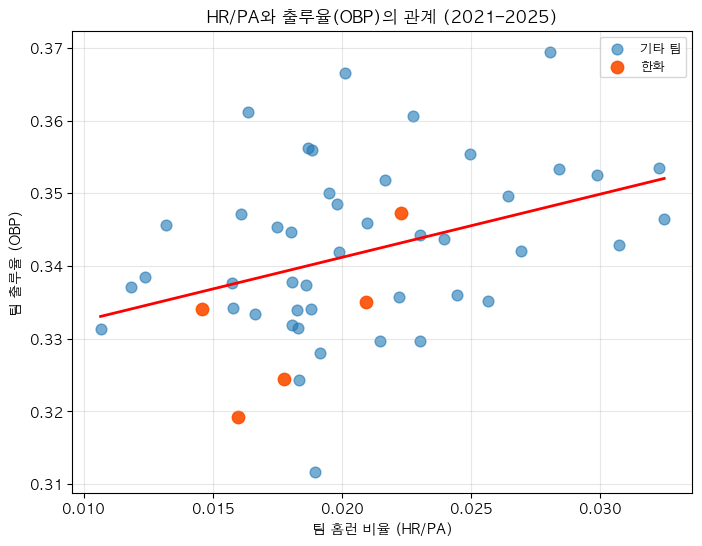

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# -----------------------------
# 데이터 준비
# -----------------------------
df = team_year.copy()

x = df["HR_PA"].astype(float)
y = df["OBP"].astype(float)

mask = ~(x.isna() | y.isna())
df = df[mask].copy()

df_hanhwa = df[df["Team"] == "한화"]
df_others = df[df["Team"] != "한화"]

# -----------------------------
# 회귀선 (전체 기준)
# -----------------------------
X = sm.add_constant(df["HR_PA"])
model = sm.OLS(df["OBP"], X).fit()

def reg_line(x_vals):
    return model.params.iloc[0] + model.params.iloc[1] * x_vals

# -----------------------------
# 그래프
# -----------------------------
plt.figure(figsize=(8, 6))

# 기타 팀
plt.scatter(
    df_others["HR_PA"],
    df_others["OBP"],
    alpha=0.6,
    s=60,
    label="기타 팀"
)

# 한화 강조
plt.scatter(
    df_hanhwa["HR_PA"],
    df_hanhwa["OBP"],
    color="#FC4E00",
    s=80,
    alpha=0.9,
    label="한화"
)

# 회귀선
x_sorted = np.sort(df["HR_PA"].values)
plt.plot(
    x_sorted,
    reg_line(x_sorted),
    color="red",
    linewidth=2
)

plt.xlabel("팀 홈런 비율 (HR/PA)")
plt.ylabel("팀 출루율 (OBP)")
plt.title("HR/PA와 출루율(OBP)의 관계 (2021–2025)")

plt.legend(
    loc="upper right",
    fontsize=9,
    frameon=True
)

plt.grid(alpha=0.3)
plt.show()
